In [1]:
import os
from datetime import datetime
from itertools import chain
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision 
import torch.distributions as dist
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter

In [16]:
nz = 64
nc_gaussian = 1

seed = 1
nfg = 64
nfd = 64
nc = 1
model_name = f'infogan_seed={seed}'
model_name = f'{model_name}_{datetime.now().strftime("%Y.%m.%d-%H:%M:%S")}'
model_name = 'jpt_test'
data_root = './data'
figure_root = os.path.join('./figures', model_name)
model_root = os.path.join('./models', model_name)
log_root = os.path.join('./logs', model_name)
load_weights_generator     = 'models/infogan_seed=3_2020.02.14-02:07:54/G_epoch_7.pt'
load_weights_discriminator = 'models/infogan_seed=3_2020.02.14-02:07:54/D_epoch_7.pt'
image_size = 32
batch_size = 32
lr = 0.0002
beta1 = 0.5
n_epochs = 10
n_batches_print = 100
n_workers = 8
gpu_id = '1'

weight_param = 1

In [17]:

class Generator(nn.Module):

    def __init__(self, nz, nf, nc, nc_gaussian):
        """
            nz      dimension of noise and latent codes
            nf      dimension of features in last conv layer
            nc      number of channels in the image
        """
        super(Generator, self).__init__()

        def block(in_channels, out_channels, stride=2, padding=1, batch_norm=True, nonlinearity=nn.ReLU(True)):
            return [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False),
                *( [nn.BatchNorm2d(out_channels)] if batch_norm else [] ),
                nonlinearity,
            ]

        self.conv_blocks = nn.Sequential(
            # (nz+1+nc_gaussian)   x 1 x 1
            *block(nz+10+nc_gaussian,   4*nf, stride=1, padding=0),
            # (4*nf) x 4 x 4
            *block(4*nf, 2*nf),
            # (2*nf) x 8 x 8
            *block(2*nf,   nf),
            # (nf) x 16 x 16
            *block(nf,     nc, batch_norm=False, nonlinearity=nn.Tanh()),
            # (nc) x 32 x 32
        )

    def forward(self, z, c):
        """
            z       (N, nz, 1, 1) or (N, nz)
                incompressible noise vector
            c       (N, 10+nc_gaussian, 1)
                latent code vector
            Returns (N, nc, 32, 32)
                image generated from model distribution
        """
        if len(z.shape) != 4:
            z = z.view(z.shape[0], z.shape[1], 1, 1)
        if len(c.shape) != 4:
            c = c.view(c.shape[0], c.shape[1], 1, 1)
    
        return self.conv_blocks(torch.cat((z, c), 1))
    

class Discriminator(nn.Module):
    
    def __init__(self, nc, nf, nc_gaussian):
        """
            nc      number of channels in the image
            nf      dimension of features of first conv layer
            nc_gaussian
                    number of latent codes that 
        """
        super(Discriminator, self).__init__()
        
        def block(in_channels, out_channels,
                  stride=2, padding=1,
                  batch_norm=True,
                  nonlinearity=nn.LeakyReLU(0.2, inplace=True)):
            """ stride=1, padding=0: H_out = H_in - 3              # 4 -> 1
                stride=2, padding=1: H_out = floor((H_in-1)/2 +1)  # roughly halves
            """
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False),
                *( [nn.BatchNorm2d(out_channels)] if batch_norm else [] ),
                nonlinearity,
            ]
        
        self.conv_blocks = nn.Sequential(
            # (nc) x 32 x 32
            *block(nc,     nf, batch_norm=False),
            # (nf) x 16 x 16
            *block(nf,   2*nf),
            # (2*nf) x 8 x 8
            *block(2*nf, 4*nf),
            # (4*nf) x 4 x 4
        )
        
        n_in_units = 4*nf*16
        
        # D: discriminator 
        self.fc_y = nn.Sequential(
            nn.Linear(n_in_units, 1),
            nn.Sigmoid())
        
        # Q: variational distribution 
        
        # (1d Categorical)
        self.fc_categorical = nn.Sequential(
            nn.Linear(n_in_units, 10),
            nn.LogSoftmax(dim=1))
        
        # (2d isotropic Gaussian)
        self.fc_mu = nn.Sequential(
            nn.Linear(n_in_units, nc_gaussian))
        self.fc_logvariance = nn.Sequential(
            nn.Linear(n_in_units, nc_gaussian))

        
    def forward(self, x):
        """
            x        (N, nc, h, w)
            Returns
                y    (N, 1)
                    classification probability that x comes from data distribution
                logp (N, 10)
                    log probability for 1D categorical latent code
                mu, variance  (N, 2)
                    parameters for 2D Gaussian latent codes
        """
        h = self.conv_blocks(x)
        h = h.view(h.shape[0], -1)
        
        y = self.fc_y(h).squeeze()
        
        logp = self.fc_categorical(h)
        mu = self.fc_mu(h)
        logvariance = self.fc_logvariance(h)

        return  y, logp, mu, logvariance
    
def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def plot_one(x, color_bar=False):
    x = x.detach().cpu().numpy().transpose((1,2,0)).squeeze()
    plt.imshow(x)
    plt.axis('off')
    if color_bar:
        plt.colorbar(extend='both')
    return plt    

In [18]:
os.makedirs(data_root, exist_ok=True)
os.makedirs(model_root, exist_ok=True)
os.makedirs(figure_root, exist_ok=True)
os.makedirs(log_root, exist_ok=True)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

trainset = datasets.MNIST(root=data_root, download=True,
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

(tensor(-0.7338), tensor(0.5898))

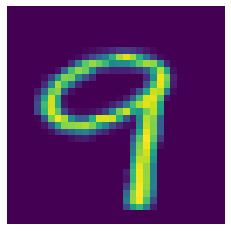

In [19]:
x = next(iter(trainloader))
plot_one(x[0][0])
torch.mean(x[0]), torch.std(x[0])

In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

G = Generator(nz, nfg, nc, nc_gaussian).to(device)
G.apply(weights_initialization)
if load_weights_generator != '':
    G.load_state_dict(torch.load(load_weights_generator))

D = Discriminator(nc, nfd, nc_gaussian).to(device)
D.apply(weights_initialization)
if load_weights_discriminator != '':
    D.load_state_dict(torch.load(load_weights_discriminator))

In [21]:

def logpdf_gaussian(x, mu, logvariance, reduction='mean'):
    """ Evaluate log Normal(x;μ,exp.(σ^2))
            i.e. log-pdf of x under spherical Gaussian N(x|μ,σ^2 I)

        x           (batch_size, n_x)
        mu          (batch_size, n_x)
        log_sigma2  (batch_size, n_x)

    batch dot product: https://github.com/pytorch/pytorch/issues/18027
    
    overflow problem fix: put 1/sigma^2 \circ (x-mu) first, ....
    """
    log_probs = (-mu.shape[-1]/2)*math.log(2*math.pi) - \
        (1/2)*torch.sum(logvariance,dim=1) - \
        (1/2)*torch.sum((1/torch.exp(logvariance))*(x-mu)*(x-mu),-1)
    if reduction == 'mean':
        return torch.mean(log_probs,dim=-1)
    elif reduction == 'sum':
        return torch.sum(log_probs,dim=-1)
    else:
        raise Exception

In [22]:
D_loss = nn.BCELoss()
Q_cat_loss = nn.NLLLoss()
Q_gaussian_loss = nn.CrossEntropyLoss()


# label flipping MIGHT helps with training G!
real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(chain(
    D.conv_blocks.parameters(),
    D.fc_y.parameters()),lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
# might want to remove conv_blocks parameter here, just the fcs
optimizerQ = torch.optim.Adam(chain(
    D.conv_blocks.parameters(),
    D.fc_categorical.parameters(),
    D.fc_mu.parameters(),
    D.fc_logvariance.parameters()), lr=lr, betas=(beta1, 0.999))

writer = SummaryWriter(log_root)
writer.flush()

pdf_c_cat = dist.Categorical(torch.ones(10)/10)
pdf_c_gaussian = dist.MultivariateNormal(torch.zeros(nc_gaussian), torch.eye(nc_gaussian))


def sample_latents(batch_size):

    # sample noise
    z = torch.randn(batch_size, nz, device=device)

    # sample latent codes
    c_cat = pdf_c_cat.sample(sample_shape=(batch_size,)).to(device)
    c_cat_onehot = nn.functional.one_hot(c_cat, 10)
    c_gaussian = pdf_c_gaussian.sample(sample_shape=(batch_size,)).to(device)
    c = torch.cat([c_cat_onehot.float(), c_gaussian], dim=-1)

    return z, c, c_cat, c_gaussian


fixed_z = torch.randn(100, nz, device=device)
fixed_c_cat = torch.arange(10).repeat_interleave(10)
fixed_c_cat_onehot = nn.functional.one_hot(fixed_c_cat, 10)
fixed_c_gaussian_1 = torch.linspace(-1.5,1.5,10).repeat(10).view(100,1)
fixed_c_gaussian_2 = torch.linspace(-1.5,1.5,10).repeat_interleave(10).view(100,1)
fixed_c = torch.cat([fixed_c_cat_onehot.float(), fixed_c_gaussian_1, fixed_c_gaussian_2], dim=-1).to(device)


In [ ]:


for epoch in range(n_epochs):

    for it, (x_real, _) in enumerate(trainloader):

        # batch_size for last batch might be different ...
        batch_size = x_real.size(0)
        real_labels = torch.full((batch_size,), real_label, device=device)
        fake_labels = torch.full((batch_size,), fake_label, device=device)

        ##############################################################
        # Update D: Minimize E[-log(D(x))] + E[-log(1 - D(G(c,z)))] (saturating)
        #                                    # D(x) -> p(1|x), probability of x being real
        #           Minimize E[-log(D(x))] + E[-log(D(G(c,z)))]     (non-saturating)
        #                                    # D(x) -> p(0|x), probability of x being fake
        ##############################################################

        optimizerD.zero_grad()

        # a minibatch of samples from data distribution
        x_real = x_real.to(device)

        y,_,_,_ = D(x_real)
        loss_D_real = D_loss(y, real_labels)
        loss_D_real.backward()

        D_x = y.mean().item()

        z, c, c_cat, c_gaussian = sample_latents(batch_size)
        x_fake = G(z, c)
        
        # https://github.com/pytorch/examples/issues/116
        # If we do not detach, then, although x_fake is not needed for gradient update of D,
        #   as a consequence of backward pass which clears all the variables in the graph
        #   Generator's graph will not be available for gradient update of G
        # Also for performance considerations, detaching x_fake will prevent computing 
        #   gradients for parameters in G
        y,_,_,_ = D(x_fake.detach())
        loss_D_fake = D_loss(y, fake_labels)
        loss_D_fake.backward()

        D_G_z1 = y.mean().item()
        loss_D = loss_D_real + loss_D_fake
        optimizerD.step()

        ##############################################################
        # Update G: Minimize E[-log(D(G(c,z))) - \lambda log Q(G(c,z))]
        #                    # D(x) -> p(0|x), probability of x being fake
        # Update Q: Minimize E[-\lambda log Q(x')]
        ##############################################################

        optimizerG.zero_grad()

        y, logp, mu, logvariance = D(x_fake)
        loss_bce = D_loss(y, real_labels)
        
        optimizerQ.zero_grad()
        
        loss_c_cat_nll = Q_cat_loss(logp, c_cat)
        loss_c_gaussian_nll = -logpdf_gaussian(c_gaussian, mu, logvariance)
        loss_Q = loss_c_cat_nll + loss_c_gaussian_nll

        loss_G = loss_bce - weight_param*loss_Q
        loss_G.backward()
        
        optimizerG.step()
        optimizerQ.step()


        ##############################################################
        # write/print
        ##############################################################
        

        loss_D = loss_D.item()
        loss_G = loss_G.item()
        loss_Q = loss_Q.item()

        loss_total = loss_D - weight_param*loss_Q

        if it % n_batches_print == n_batches_print-1:
            print(f'[{epoch+1}/{n_epochs}][{it+1}/{len(trainloader)}]'
                  f'loss: {loss_total:.4}\t'
                  f'loss_D: {loss_D:.4}\t'
                  f'loss_G: {loss_G:.4}\t'
                  f'loss_Q: {loss_Q:.4}')
            vutils.save_image(G(fixed_z, fixed_c).detach(),
                os.path.join(figure_root,
                     f'{model_name}_fake_samples_epoch={epoch}_it={it}.png'))

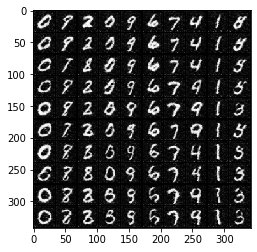

In [30]:

fixed_z = torch.randn(100, nz, device=device)
fixed_c_cat = torch.arange(10).repeat(10)
fixed_c_cat_onehot = nn.functional.one_hot(fixed_c_cat, 10)
fixed_c_gaussian = torch.linspace(-1,1,10).repeat_interleave(10).view(100,1)
fixed_c = torch.cat([fixed_c_cat_onehot.float(), fixed_c_gaussian], dim=-1).to(device)

x = G(fixed_z, fixed_c).detach()
im = vutils.make_grid(x,nrow=10,normalize=True).transpose(0,-1).transpose(0,1)
plt.imshow(im)